In [1]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from graph_toolset import coreness
import jupyternotify
import random
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    if 'total' in keys:
        return {'total': graph.V}
    else:
        return {}

In [3]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [4]:
def plot_mean_and_std(bs, data, last):
    fig, axs = plt.subplots(2)
    
    cur = np.apply_along_axis(lambda x: np.mean(x[-last:]), 2, data)
    cur = np.apply_along_axis(np.mean, 0, cur)
    axs[0].plot(bs, cur, '.-')
    
    cur = np.apply_along_axis(lambda x: np.std(x[-last:]), 2, data)
    cur = np.apply_along_axis(np.mean, 0, cur)
    axs[1].plot(bs, cur, '.-')

In [5]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [6]:
def plot_means(bs, data, last, keys, title, show_data=True):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.05)

        cur = np.apply_along_axis(np.mean, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    ax.legend()
    ax.set_title(title)
    plt.show()

In [7]:
def plot_2d(alphas, bs, data, last, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(lambda x: np.mean(x[-last:]), 3, data[key])
        cur = np.apply_along_axis(np.mean, 0, cur)
        
        CSF = ax.contourf(bs, alphas, cur, levels=100, label=str(key))
        # CS = ax.contour(x, y, z, levels=levels, colors='black', linestyles='dashed')
        fig.colorbar(CSF, ax=ax, orientation='horizontal')
        # plt.clabel(CS, fmt='%1.1f', colors='k', fontsize=14)  # contour line labels
        
    ax.legend()
    ax.set_title(title)
    plt.show()

In [8]:
def plot_individual(data, prob, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        for i in range(data[key].shape[0]):
            for j in range(data[key].shape[1]):
                for k in range(data[key].shape[2]):
                    if random.uniform(0, 1) < prob:
                        ax.plot(data[key][i][j][k])
    ax.set_title(title)
    plt.show()

In [9]:
def get_er(_):
    return ErdosRenyi(1000, 4. / 1000.)

graphs_er = Pool(32).map(get_er, [() for _ in range(500)])

In [15]:
def degs(graph, keys=[]):
    sets = dict()
    for key in keys:
        sets[key] = []
    
    for v in graph.V:
        d = graph.deg(v)
        if d not in keys:
            continue
        sets[d].append(v)
    return sets

In [41]:
res = calc('fun', [.1], partition(0, 10, 256), graphs[:100], 200, set_builder=degs, keys=list(range(0, 9)))

#1 passed in 25.348682165145874,  projected end in 13.096842153867085 minutes
#2 passed in 25.683743000030518,  projected end in 12.758808612823486 minutes
#3 passed in 25.13998770713806,  projected end in 12.272845498720805 minutes
#4 passed in 24.601167917251587,  projected end in 11.757481106122334 minutes
#5 passed in 25.189961433410645,  projected end in 11.337247495651244 minutes
#6 passed in 25.238178968429565,  projected end in 10.92060386074914 minutes
#7 passed in 26.583986520767212,  projected end in 10.582957565784454 minutes
#8 passed in 25.37334704399109,  projected end in 10.158387625217438 minutes
#9 passed in 25.454793214797974,  projected end in 9.737676320252596 minutes
#10 passed in 25.606987953186035,  projected end in 9.321828228632608 minutes
#11 passed in 25.053379774093628,  projected end in 8.886383287473159 minutes
#12 passed in 26.807987689971924,  projected end in 8.502642154693604 minutes
#13 passed in 26.115466117858887,  projected end in 8.09232863829686

<IPython.core.display.Javascript object>


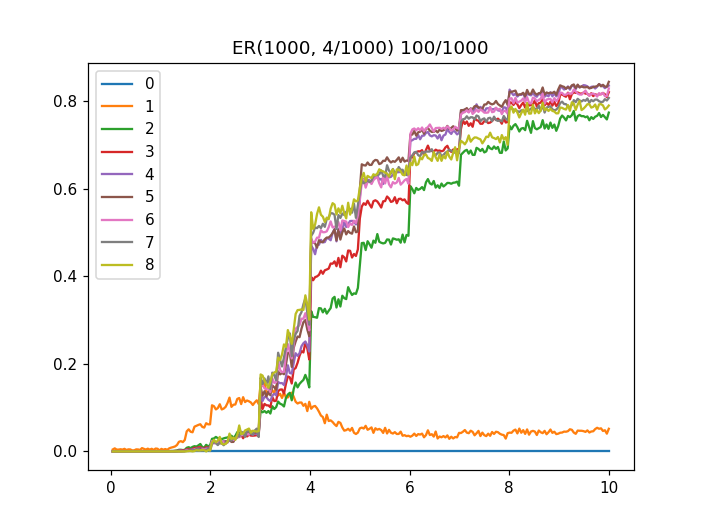

In [42]:
plot_means(partition(0, 10, 256), res, 20, list(range(0, 9)), 'ER(1000, 4/1000) 100/1000', show_data=False)

<IPython.core.display.Javascript object>


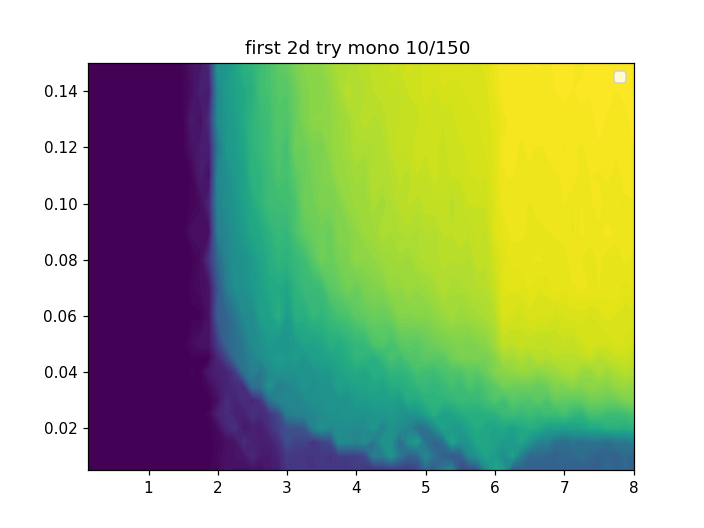

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  
No handles with labels found to put in legend.


In [94]:
plot_2d(alphas, bs, res, 10, keys=[3], title='first 2d try mono 10/150 ')

In [44]:
res32 = calc('mono', [.1], partition(0, 8, 64), graphs23[:200], 150, set_builder=degs, keys=[2, 3], init_type='01')

#1 passed in 7.3502678871154785,  projected end in 24.378523711363474 minutes
#2 passed in 7.331288576126099,  projected end in 24.228404116630553 minutes
#3 passed in 7.413574457168579,  projected end in 24.18572878175312 minutes
#4 passed in 7.355705261230469,  projected end in 24.054916409651437 minutes
#5 passed in 7.279771089553833,  projected end in 23.878029036521912 minutes
#6 passed in 7.329169988632202,  projected end in 23.74632997115453 minutes
#7 passed in 7.317704916000366,  projected end in 23.61214362950552 minutes
#8 passed in 7.3134777545928955,  projected end in 23.47929992675781 minutes
#9 passed in 7.2531421184539795,  projected end in 23.327502050664688 minutes
#10 passed in 7.283041000366211,  projected end in 23.191360306739806 minutes
#11 passed in 7.309677600860596,  projected end in 23.065518782355568 minutes
#12 passed in 7.294196128845215,  projected end in 22.936306888527337 minutes
#13 passed in 7.332743406295776,  projected end in 22.81751869152754 minut

#107 passed in 7.347472190856934,  projected end in 11.318410329618187 minutes
#108 passed in 7.305601119995117,  projected end in 11.196767476605778 minutes
#109 passed in 7.342131853103638,  projected end in 11.075629199535475 minutes
#110 passed in 7.311952590942383,  projected end in 10.954055483774706 minutes
#111 passed in 7.37550950050354,  projected end in 10.833326850710687 minutes
#112 passed in 7.329156160354614,  projected end in 10.711951619102843 minutes
#113 passed in 7.26366925239563,  projected end in 10.589721452451386 minutes
#114 passed in 7.2748284339904785,  projected end in 10.467651916526215 minutes
#115 passed in 7.298286199569702,  projected end in 10.34588855954184 minutes
#116 passed in 7.250508546829224,  projected end in 10.223555321117926 minutes
#117 passed in 7.27248740196228,  projected end in 10.101499378715147 minutes
#118 passed in 7.263628244400024,  projected end in 9.979355439223811 minutes
#119 passed in 7.259366035461426,  projected end in 9.85

<IPython.core.display.Javascript object>


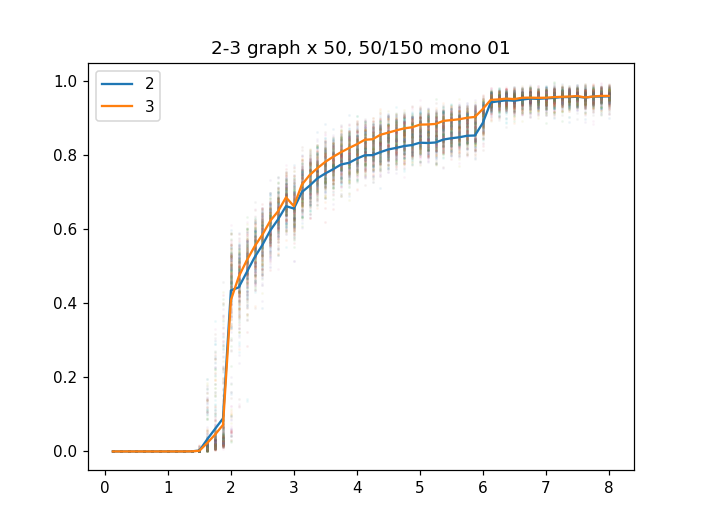

In [46]:
plot_means(partition(0, 8, 64), res32, 50, [2, 3], '2-3 graph x 50, 50/150 mono 01')

<IPython.core.display.Javascript object>


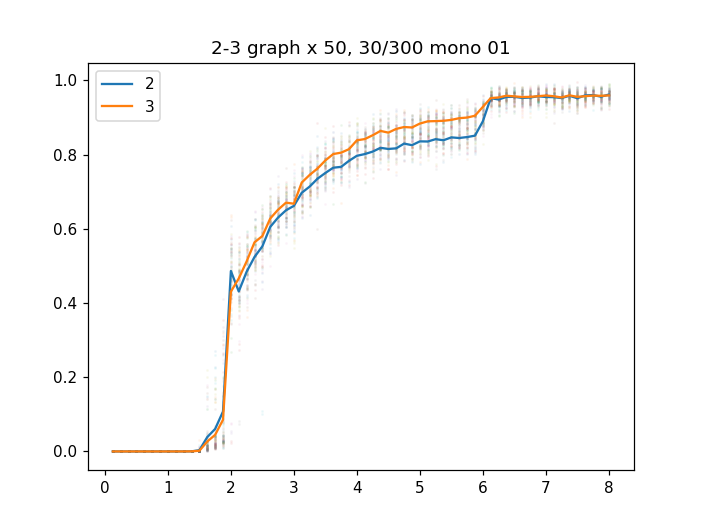

In [30]:
plot_means(partition(0, 8, 64), res32, 50, [2, 3], '2-3 graph x 50, 30/300 mono 01')

<IPython.core.display.Javascript object>


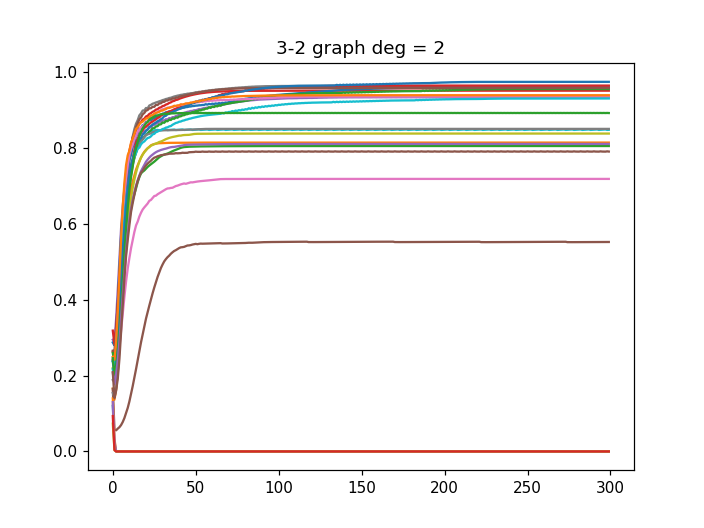

In [42]:
plot_individual(res32[2], .01, '3-2 graph deg = 2')

<IPython.core.display.Javascript object>


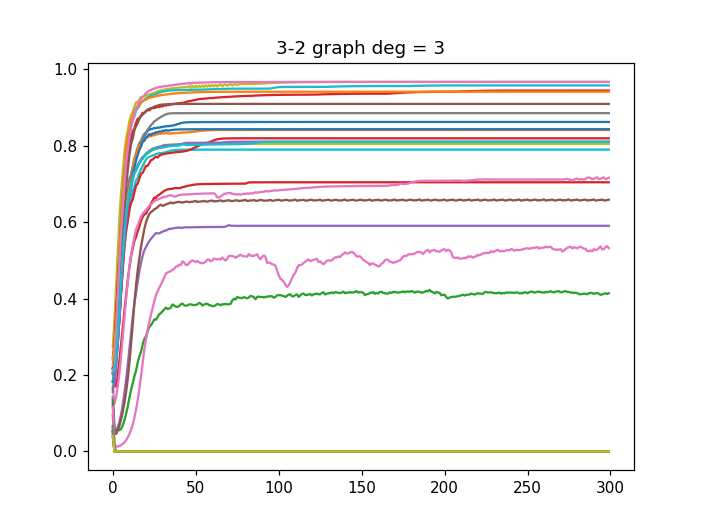

In [43]:
plot_individual(res32[3], .01, '3-2 graph deg = 3')

<IPython.core.display.Javascript object>


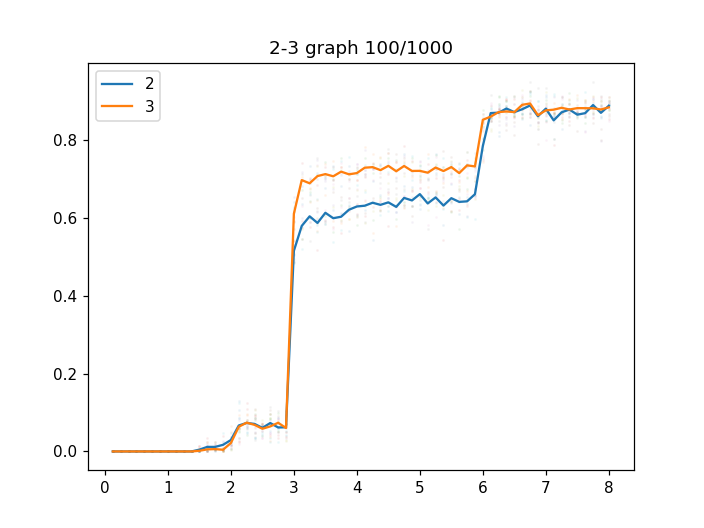

In [13]:
plot_means(partition(0, 8, 64), res32, 100, [2, 3], '2-3 graph 100/1000')

<IPython.core.display.Javascript object>


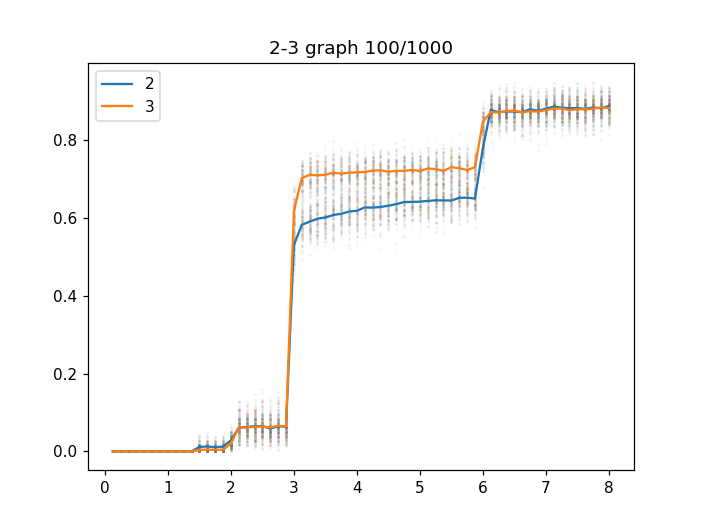

In [65]:
plot_means(partition(0, 8, 64), res32, 100, [2, 3], '2-3 graph 100/1000')

In [55]:
graphs24 = Pool(32).map(GraphByDegrees, [{2: 300, 4: 300} for _ in range(500)])

In [68]:
res24s = calc('fun', [.1], partition(0, 32, 128), graphs24[:10], 100, set_builder=degs, keys=[2, 4])

#1 passed in 3.288069248199463,  projected end in 0.49321961402893066 minutes
#2 passed in 3.2213168144226074,  projected end in 0.4341136455535889 minutes
#3 passed in 3.315054178237915,  projected end in 0.3822038782967462 minutes
#4 passed in 3.2563977241516113,  projected end in 0.3271306395530701 minutes
#5 passed in 3.2405991554260254,  projected end in 0.27210941712061565 minutes
#6 passed in 3.247330665588379,  projected end in 0.21749903361002604 minutes
#7 passed in 3.2471911907196045,  projected end in 0.1630234718322754 minutes
#8 passed in 3.30826997756958,  projected end in 0.10888534386952718 minutes
#9 passed in 3.2445874214172363,  projected end in 0.05440330328764739 minutes
#10 passed in 3.2291996479034424,  projected end in 0.0 minutes
time elapsed = 32.62696647644043


<IPython.core.display.Javascript object>


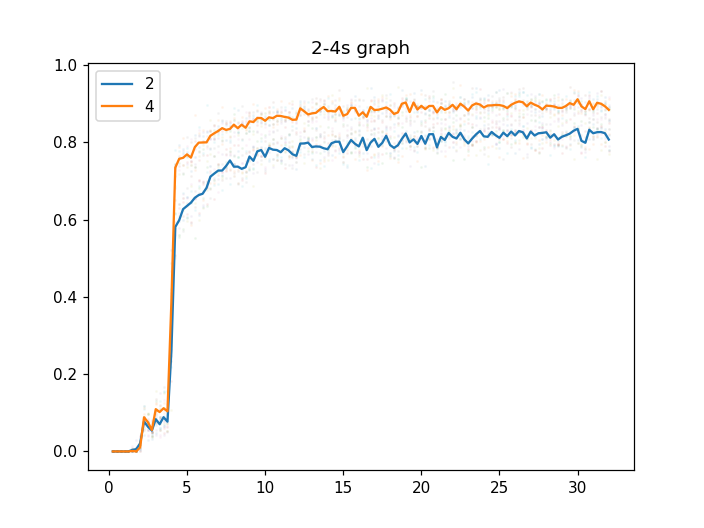

In [69]:
plot_means(partition(0, 32, 128), res24s, 10, keys=[2, 4], title='2-4s graph')

<IPython.core.display.Javascript object>


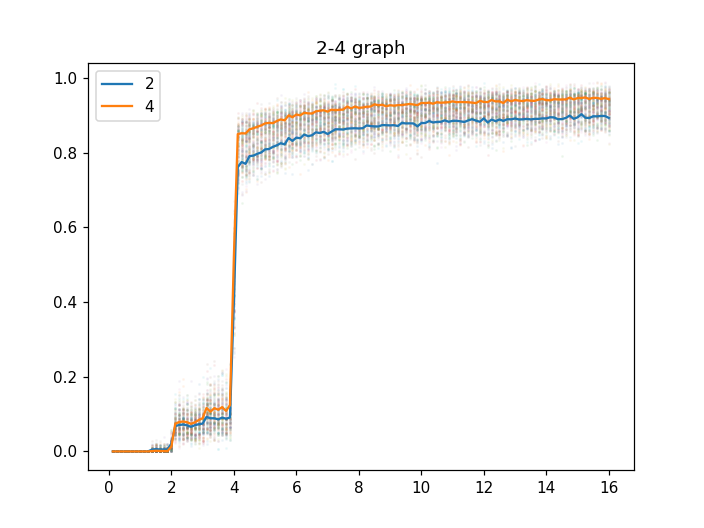

In [64]:
plot_means(partition(0, 16, 128), res24, 40, keys=[2, 4], title='2-4 graph')

In [26]:
res = calc('mono', [.1], partition(0, 8, 64), graphs_er, 500, set_builder=degs, keys=list(range(0, 10)), init_type='01')

#1 passed in 9.601455688476562,  projected end in 15.842607235908508 minutes
#2 passed in 9.260080575942993,  projected end in 15.4084143837293 minutes
#3 passed in 9.34520936012268,  projected end in 15.203970715734695 minutes
#4 passed in 9.218264102935791,  projected end in 14.973044300079346 minutes
#5 passed in 10.403075456619263,  projected end in 15.148374617099762 minutes
#6 passed in 9.51789379119873,  projected end in 14.976242060131495 minutes
#7 passed in 9.9485342502594,  projected end in 14.903297580991474 minutes
#8 passed in 9.661626815795898,  projected end in 14.752138022581736 minutes
#9 passed in 10.232845067977905,  projected end in 14.695049100452 minutes
#10 passed in 10.49817156791687,  projected end in 14.65507789850235 minutes
#11 passed in 9.792463541030884,  projected end in 14.495377240036474 minutes
#12 passed in 9.62291145324707,  projected end in 14.314367734061346 minutes
#13 passed in 9.491410970687866,  projected end in 14.121888300088736 minutes
#14 

<IPython.core.display.Javascript object>


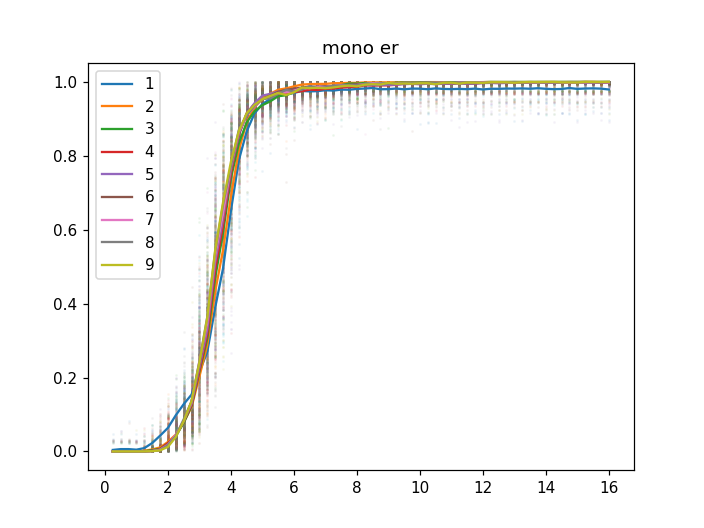

In [27]:
plot_means(partition(0, 16, 64), res, 10, list(range(1, 10)), 'mono er')

In [21]:
res_uniform = calc('mono', [.1], partition(0, 8, 64), graphs_er[:100], 200, set_builder=degs, keys=list(range(0, 10)), init_type='uniform')

#1 passed in 17.798150062561035,  projected end in 29.367030215263366 minutes
#2 passed in 17.65656542778015,  projected end in 28.956883160273232 minutes
#3 passed in 17.549299240112305,  projected end in 28.565220708317227 minutes
#4 passed in 17.748900890350342,  projected end in 28.302916049957275 minutes
#5 passed in 17.985955476760864,  projected end in 28.1022598584493 minutes
#6 passed in 17.505053520202637,  projected end in 27.742989940113493 minutes
#7 passed in 17.73965287208557,  projected end in 27.454951802321844 minutes
#8 passed in 17.726154804229736,  projected end in 27.162422396739323 minutes
#9 passed in 17.662979125976562,  projected end in 26.858598900724342 minutes
#10 passed in 17.749670267105103,  projected end in 26.569675970077515 minutes
#11 passed in 17.956108331680298,  projected end in 26.30742606249722 minutes
#12 passed in 18.130030632019043,  projected end in 26.06017959382799 minutes
#13 passed in 17.891088008880615,  projected end in 25.777838973815

<IPython.core.display.Javascript object>


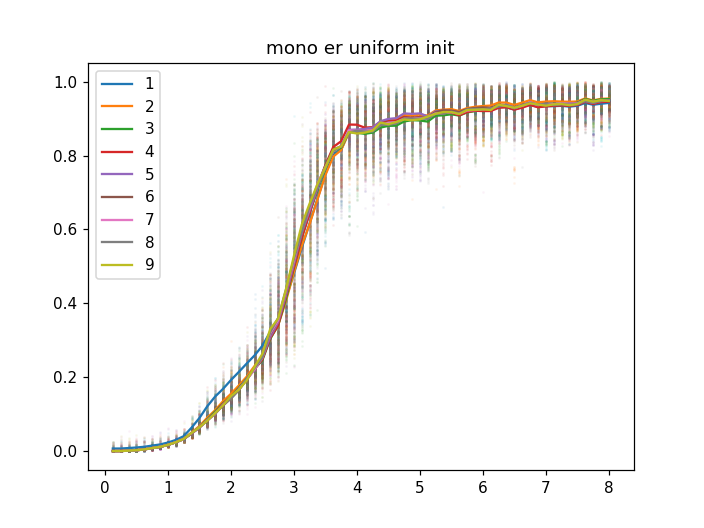

In [23]:
plot_means(partition(0, 8, 64), res_uniform, 20, list(range(1, 10)), 'mono er uniform init')

In [19]:
res = calc('mono', [.1], partition(0, 8, 64), graphs_er[:100], 200, set_builder=degs, keys=list(range(0, 10)), init_type='01')

#1 passed in 17.849313020706177,  projected end in 29.451442408561707 minutes
#2 passed in 17.80307364463806,  projected end in 29.118265942732492 minutes
#3 passed in 17.595359563827515,  projected end in 28.696659081512028 minutes
#4 passed in 17.758459329605103,  projected end in 28.40434856414795 minutes
#5 passed in 17.7610445022583,  projected end in 28.111364686489104 minutes
#6 passed in 17.557687997817993,  projected end in 27.76425955295563 minutes
#7 passed in 17.73770236968994,  projected end in 27.472558215686256 minutes
#8 passed in 17.61832880973816,  projected end in 27.15699465672175 minutes
#9 passed in 17.768054962158203,  projected end in 26.871530775229136 minutes
#10 passed in 17.851834535598755,  projected end in 26.59650067090988 minutes
#11 passed in 17.80208992958069,  projected end in 26.310680035027588 minutes
#12 passed in 18.124247312545776,  projected end in 26.06241685019599 minutes
#13 passed in 17.783950805664062,  projected end in 25.76791165333528 mi

<IPython.core.display.Javascript object>


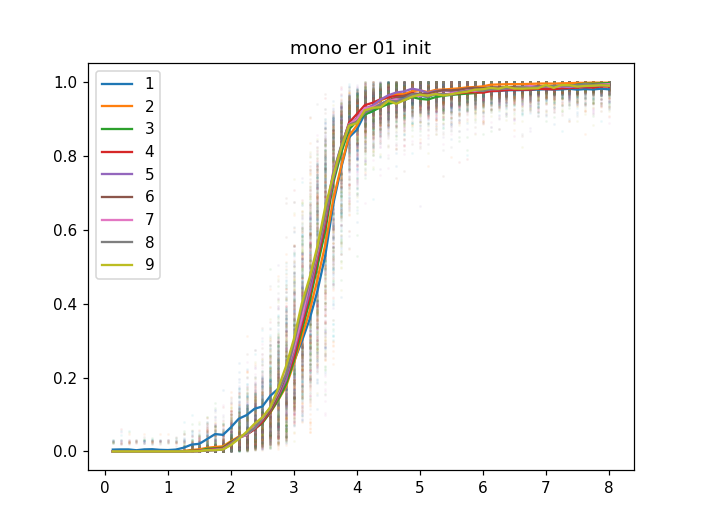

In [20]:
plot_means(partition(0, 8, 64), res, 50, list(range(1, 10)), 'mono er 01 init')

In [10]:
alphas = np.concatenate((partition(0, .05, 10), partition(.05, .15, 10)))
bs = partition(0, 8, 64)
alphas

array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.06 , 0.07 , 0.08 , 0.09 , 0.1  , 0.11 , 0.12 , 0.13 ,
       0.14 , 0.15 ])

In [20]:
res = calc('sum', alphas, bs, graphs_er[:10], 50, set_builder=total, keys=['total'], init_type='01')

/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#1 passed in 110.73846125602722,  projected end in 16.610773730278016 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#2 passed in 110.76196002960205,  projected end in 14.766820462544759 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#3 passed in 112.17339563369751,  projected end in 12.976311906178791 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#4 passed in 111.9086663722992,  projected end in 11.139651316404343 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#5 passed in 115.61275672912598,  projected end in 9.353329646587373 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#6 passed in 110.7385663986206,  projected end in 7.466001020537482 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#7 passed in 111.91416478157043,  projected end in 5.598965736797878 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#8 passed in 111.88473010063171,  projected end in 3.7322533667087554 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#9 passed in 111.8911395072937,  projected end in 1.865986865979654 minutes


/home/zhuk1996/evolutionary-games/engine_sum.py:37: RuntimeWarning: invalid value encountered in true_divide
  p.mixed_s /= np.sum(p.mixed_s)


#10 passed in 112.87307453155518,  projected end in 0.0 minutes
time elapsed = 1120.5149092674255


<IPython.core.display.Javascript object>


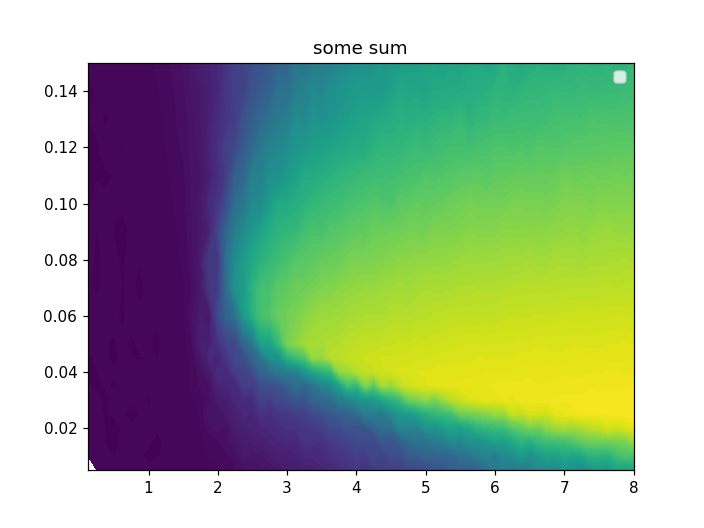

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  
No handles with labels found to put in legend.


In [21]:
plot_2d(alphas, bs, res, 5, ['total'], 'some sum')

In [15]:
def get_er(tuple):
    return ErdosRenyi(*tuple)

graphs_er = Pool(32).map(get_er, [(1000, 4. / 1000) for _ in range(500)])

In [19]:
alphas = np.concatenate((partition(0, .05, 10), partition(.05, .15, 10)))
bs = partition(0, 8, 32)
alphas

array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.06 , 0.07 , 0.08 , 0.09 , 0.1  , 0.11 , 0.12 , 0.13 ,
       0.14 , 0.15 ])

In [28]:
res_fun = calc('fun', alphas, bs, graphs_er[:20], 500)

#1 passed in 156.77905750274658,  projected end in 49.64671203692754 minutes
#2 passed in 153.67119669914246,  projected end in 46.567847764492036 minutes
#3 passed in 158.8926169872284,  projected end in 44.327098845111 minutes
#4 passed in 157.79935264587402,  projected end in 41.80973037083944 minutes
#5 passed in 159.46831464767456,  projected end in 39.330774295330045 minutes
#6 passed in 160.14345264434814,  projected end in 36.818456784884134 minutes
#7 passed in 162.84004521369934,  projected end in 34.344804216566544 minutes
#8 passed in 163.97750663757324,  projected end in 31.839505088329314 minutes
#9 passed in 154.68579125404358,  projected end in 29.094329214537588 minutes
#10 passed in 158.29540824890137,  projected end in 26.442732071876527 minutes
#11 passed in 161.98294234275818,  projected end in 23.843839456818323 minutes
#12 passed in 162.10210824012756,  projected end in 21.229460623529224 minutes
#13 passed in 160.8445429801941,  projected end in 18.5903619264945

In [29]:
res_mono = calc('mono', alphas, bs, graphs_er[:20], 200)

#1 passed in 182.9410331249237,  projected end in 57.931336065133415 minutes
#2 passed in 181.48240280151367,  projected end in 54.66385778188705 minutes
#3 passed in 184.1787509918213,  projected end in 51.812749658690564 minutes
#4 passed in 179.87682127952576,  projected end in 48.56563696861267 minutes
#5 passed in 182.86696195602417,  projected end in 45.567627131938934 minutes
#6 passed in 183.6101279258728,  projected end in 42.58193003204134 minutes
#7 passed in 185.54590845108032,  projected end in 39.6349059854235 minutes
#8 passed in 186.6223921775818,  projected end in 36.67840995788574 minutes
#9 passed in 180.13543224334717,  projected end in 33.55555774547436 minutes
#10 passed in 181.57784414291382,  projected end in 30.480861039956412 minutes
#11 passed in 187.10356855392456,  projected end in 27.490313419428738 minutes
#12 passed in 188.17783164978027,  projected end in 24.490391635894774 minutes
#13 passed in 184.8872594833374,  projected end in 21.43995475004881 min

In [30]:
res_sum = calc('sum', alphas, bs, graphs_er[:20], 200)

#1 passed in 238.22833037376404,  projected end in 75.43898125092188 minutes
#2 passed in 236.65551781654358,  projected end in 71.23315944671631 minutes
#3 passed in 230.1414351463318,  projected end in 66.58630050685672 minutes
#4 passed in 225.90940284729004,  projected end in 62.062786149978635 minutes
#5 passed in 225.60476446151733,  projected end in 57.8274209856987 minutes
#6 passed in 228.3339765071869,  projected end in 53.85665154457092 minutes
#7 passed in 236.41810250282288,  projected end in 50.18323308059147 minutes
#8 passed in 248.86062026023865,  projected end in 46.75416382551193 minutes
#9 passed in 246.20007419586182,  projected end in 43.11122508534679 minutes
#10 passed in 250.46369814872742,  projected end in 39.44723955392838 minutes
#11 passed in 254.3791687488556,  projected end in 35.74384442242709 minutes
#12 passed in 253.53113651275635,  projected end in 31.941645765304564 minutes
#13 passed in 249.12677693367004,  projected end in 28.034783649750246 minu

<IPython.core.display.Javascript object>


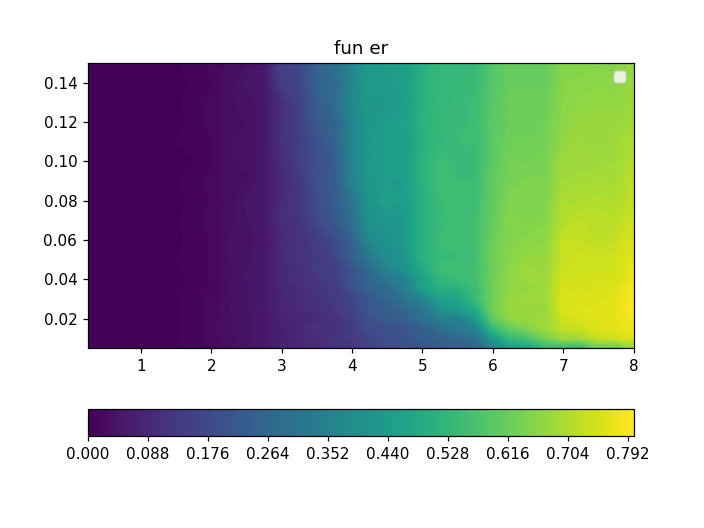

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  
No handles with labels found to put in legend.


In [37]:
plot_2d(alphas, bs, res_fun, 50, keys=['total'], title='fun er')

<IPython.core.display.Javascript object>


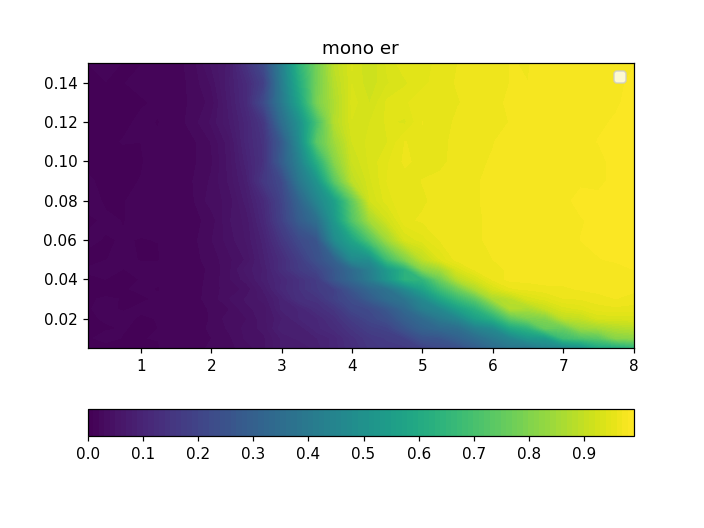

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  
No handles with labels found to put in legend.


In [36]:
plot_2d(alphas, bs, res_mono, 20, keys=['total'], title='mono er')

<IPython.core.display.Javascript object>


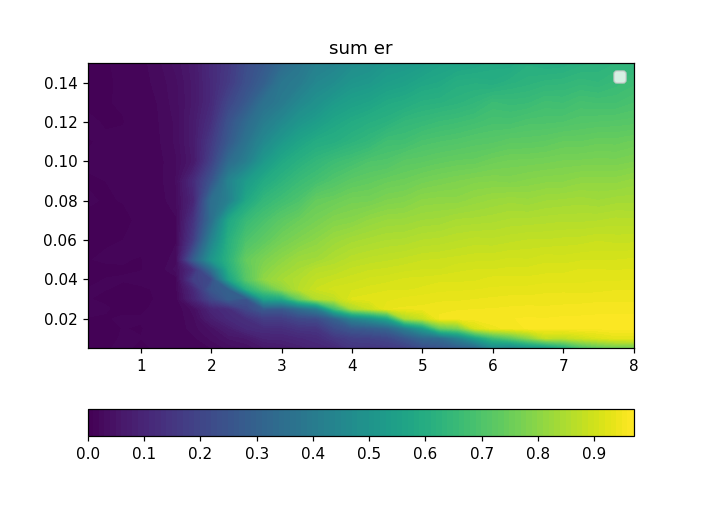

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  
No handles with labels found to put in legend.


In [35]:
plot_2d(alphas, bs, res_sum, 20, keys=['total'], title='sum er')

<IPython.core.display.Javascript object>


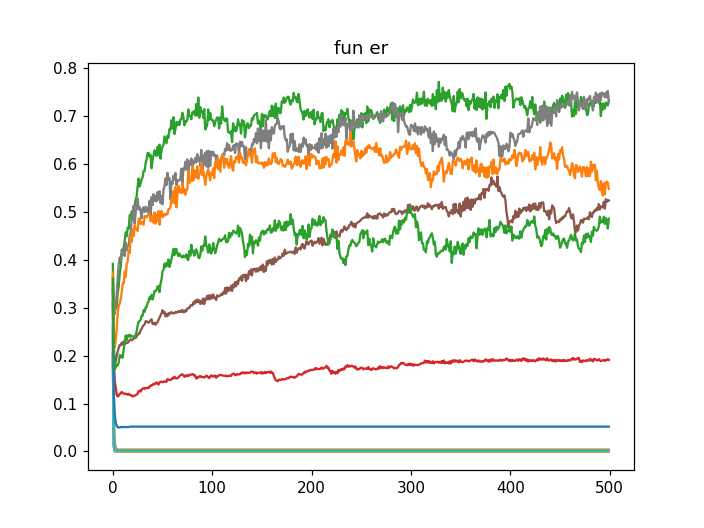

In [56]:
plot_individual(res_fun, .001, ['total'], 'fun er')

<IPython.core.display.Javascript object>


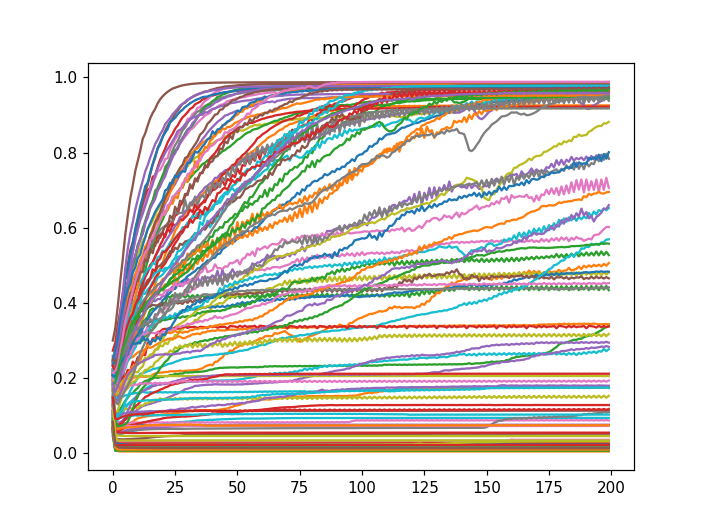

In [62]:
plot_individual(res_mono, .01, ['total'], 'mono er')

<IPython.core.display.Javascript object>


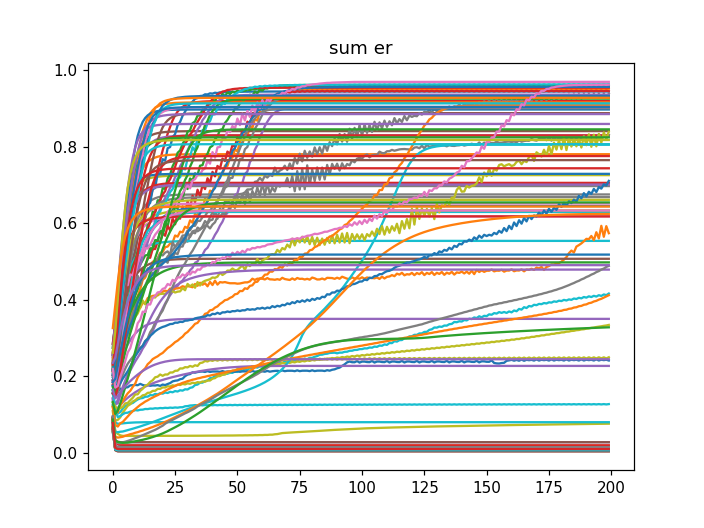

In [61]:
plot_individual(res_sum, .01, ['total'], 'sum er')

In [50]:
res_fun['total'].shape

(20, 20, 32, 500)

In [96]:
alphas[14]

0.09999999999999998

<IPython.core.display.Javascript object>


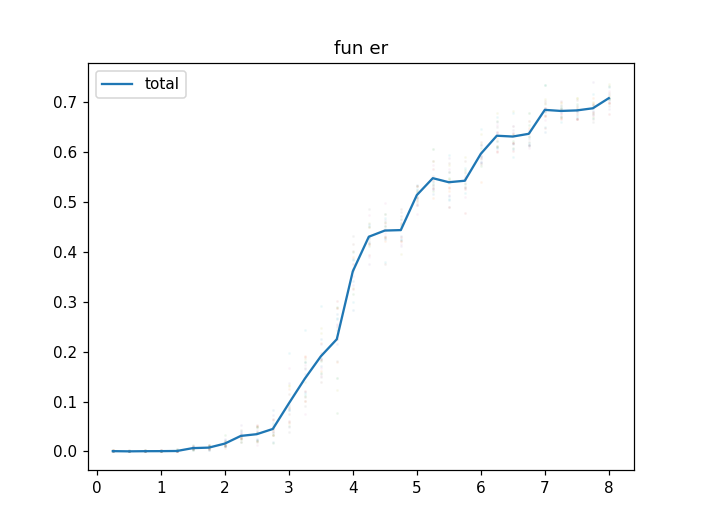

In [98]:
plot_means(bs, cut_alpha(res_fun, 14), 50, ['total'], 'fun er', show_data=True)

<IPython.core.display.Javascript object>


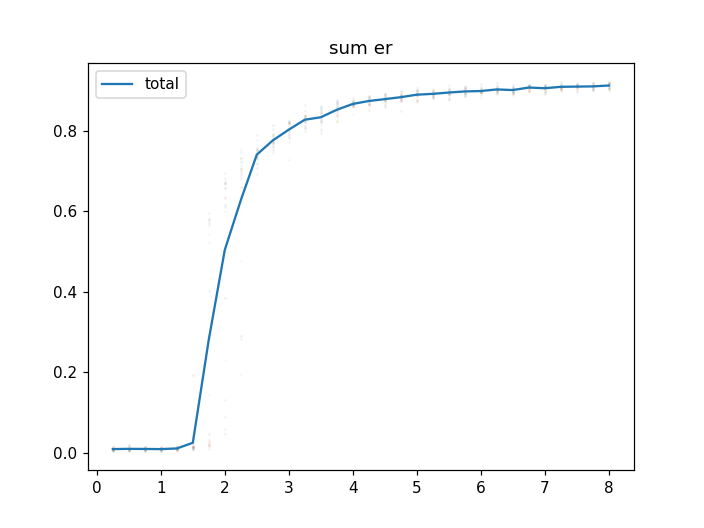

In [104]:
plot_means(bs, cut_alpha(res_sum, 9), 20, ['total'], 'sum er', show_data=True)

<IPython.core.display.Javascript object>


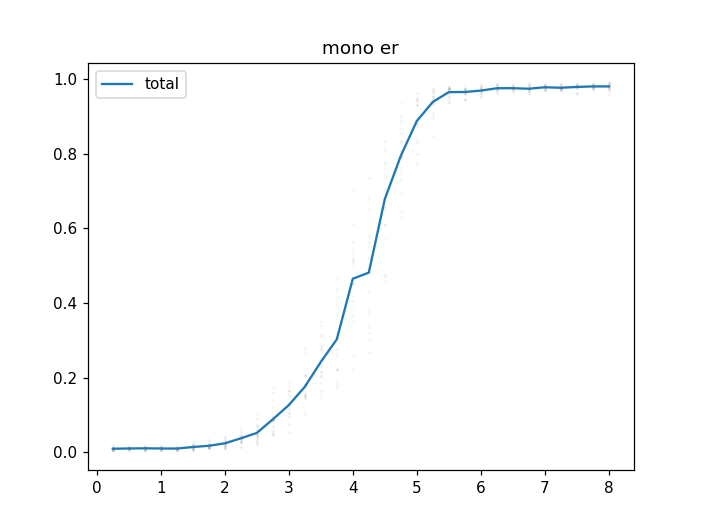

In [106]:
plot_means(bs, cut_alpha(res_mono, 9), 20, ['total'], 'mono er', show_data=True)

In [108]:
alphas05 = [.05]
bs128 = partition(0, 8, 128)

In [117]:
line_fun = calc('fun', alphas05, bs128, graphs_er[:10], 1000)

#1 passed in 66.21920347213745,  projected end in 9.932893431186676 minutes
#2 passed in 65.71303462982178,  projected end in 8.79564479192098 minutes
#3 passed in 71.19275736808777,  projected end in 7.899457761976453 minutes
#4 passed in 88.55480766296387,  projected end in 7.292131543159485 minutes
#5 passed in 72.10810732841492,  projected end in 6.06327786842982 minutes
#6 passed in 60.413917541503906,  projected end in 4.713462331559923 minutes
#7 passed in 60.395529985427856,  projected end in 3.4614854420934407 minutes
#8 passed in 59.7446928024292,  projected end in 2.2681416551272076 minutes
#9 passed in 57.640273094177246,  projected end in 1.1148062798711988 minutes
#10 passed in 58.4105122089386,  projected end in 0.0 minutes
time elapsed = 660.4150698184967


In [123]:
line_mono = calc('mono', alphas05, bs128, graphs_er[:50], 500)

#1 passed in 94.30778384208679,  projected end in 77.0180933713913 minutes
#2 passed in 93.11312079429626,  projected end in 74.9697678565979 minutes
#3 passed in 93.75554084777832,  projected end in 73.41952230268056 minutes
#4 passed in 92.40613794326782,  projected end in 71.60485814809799 minutes
#5 passed in 92.51616954803467,  projected end in 69.91615011692048 minutes
#6 passed in 92.11195874214172,  projected end in 68.22702611287436 minutes
#7 passed in 93.83041381835938,  projected end in 66.7577372556641 minutes
#8 passed in 91.25530409812927,  projected end in 65.03948868513108 minutes
#9 passed in 89.04988288879395,  projected end in 63.197645913671565 minutes
#10 passed in 91.1165246963501,  projected end in 61.5652366956075 minutes
#11 passed in 91.56602120399475,  projected end in 59.979960999705575 minutes
#12 passed in 98.96998906135559,  projected end in 58.79530441827244 minutes
#13 passed in 94.62190675735474,  projected end in 57.332877877431045 minutes
#14 passed

In [125]:
line_sum = calc('sum', alphas05, bs128, graphs_er[:50], 500)

#1 passed in 114.23779582977295,  projected end in 93.29422874450684 minutes
#2 passed in 114.23660659790039,  projected end in 91.3906455039978 minutes
#3 passed in 115.05471134185791,  projected end in 89.7000743455357 minutes
#4 passed in 113.96507954597473,  projected end in 87.68741386135419 minutes
#5 passed in 113.23841571807861,  projected end in 85.61081389188766 minutes
#6 passed in 113.39271903038025,  projected end in 83.61617884635925 minutes
#7 passed in 114.48092341423035,  projected end in 81.76291805505753 minutes
#8 passed in 114.71112203598022,  projected end in 79.91607149839402 minutes
#9 passed in 112.96790552139282,  projected end in 77.92244896667975 minutes
#10 passed in 113.84821844100952,  projected end in 76.00964295069376 minutes
#11 passed in 116.50331902503967,  projected end in 74.2565325043418 minutes
#12 passed in 116.34371256828308,  projected end in 72.4635583784845 minutes
#13 passed in 115.41027593612671,  projected end in 70.60381493354456 minutes

<IPython.core.display.Javascript object>


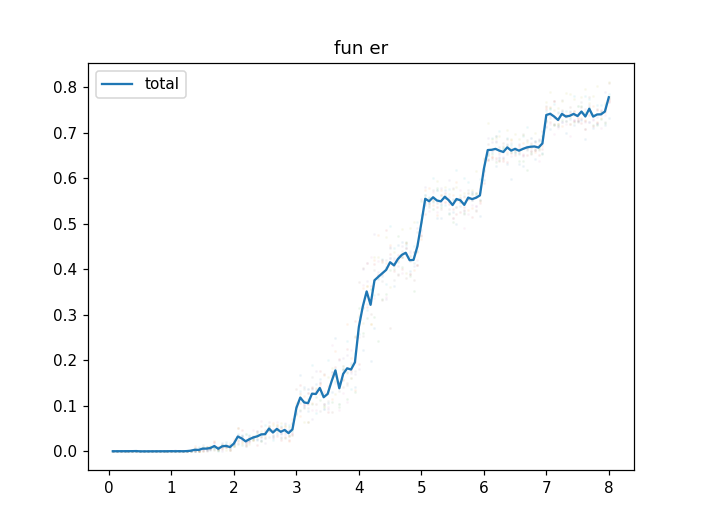

In [120]:
plot_means(bs128, cut_alpha(line_fun, 0), 100, ['total'], 'fun er')

<IPython.core.display.Javascript object>


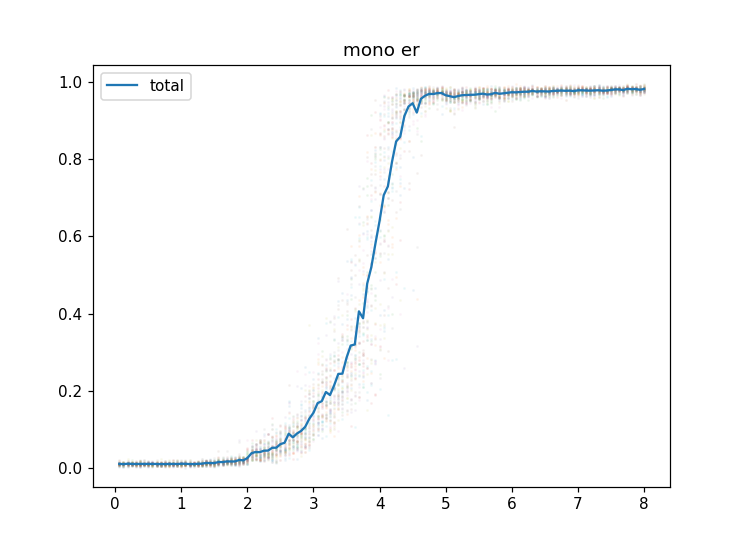

In [124]:
plot_means(bs128, cut_alpha(line_mono, 0), 50, ['total'], 'mono er')

<IPython.core.display.Javascript object>


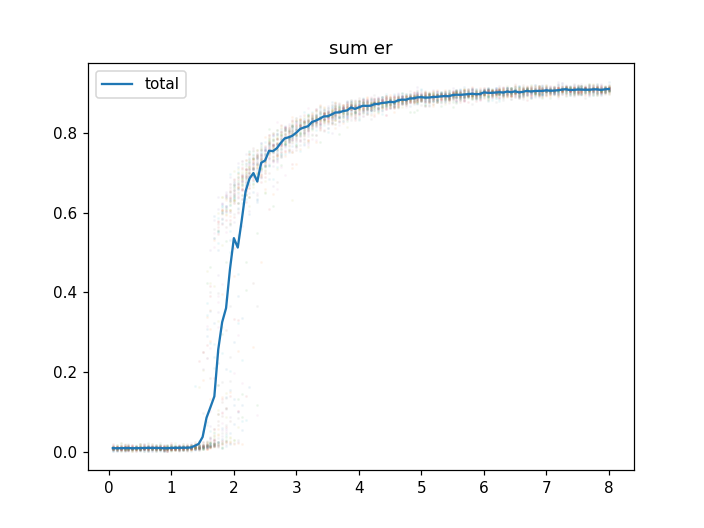

In [126]:
plot_means(bs128, cut_alpha(line_sum, 0), 50, ['total'], 'sum er')

In [11]:
bs = partition(0, 8, 64)
alphas = [.1]
def ER(t):
    return ErdosRenyi(*t)
graphs = Pool(32).map(ER, [(500, 4. / 500) for _ in range(100)])

In [14]:
res = calc('fun', alphas, bs, graphs[:10], 10000, set_builder=coreness, keys=list(range(9)))

#1 passed in 154.65074253082275,  projected end in 23.197615921497345 minutes
#2 passed in 148.87244176864624,  projected end in 20.2351260026296 minutes
#3 passed in 151.00033378601074,  projected end in 17.676143291261457 minutes
#4 passed in 155.98482537269592,  projected end in 15.262897646427154 minutes
#5 passed in 149.2190968990326,  projected end in 12.66229540904363 minutes
#6 passed in 152.69792485237122,  projected end in 10.138191771507262 minutes
#7 passed in 151.98915123939514,  projected end in 7.603063998903546 minutes
#8 passed in 152.3142364025116,  projected end in 5.069772065679232 minutes
#9 passed in 150.7535104751587,  projected end in 2.53240879729942 minutes
#10 passed in 153.18252849578857,  projected end in 0.0 minutes
time elapsed = 1520.8780181407928


In [16]:
res_mono = calc('mono', alphas, bs, graphs[:10], 100, set_builder=coreness, keys=list(range(9)))

#1 passed in 4.442782878875732,  projected end in 0.6664224028587341 minutes
#2 passed in 5.27104115486145,  projected end in 0.6477564493815104 minutes
#3 passed in 4.488631248474121,  projected end in 0.5524477521578471 minutes
#4 passed in 4.513760089874268,  projected end in 0.4680059254169464 minutes
#5 passed in 4.538361310958862,  projected end in 0.38765519857406616 minutes
#6 passed in 4.568868637084961,  projected end in 0.3092147058910794 minutes
#7 passed in 4.521650791168213,  projected end in 0.2310833845819746 minutes
#8 passed in 4.420470476150513,  projected end in 0.1532203326622645 minutes
#9 passed in 4.4695799350738525,  projected end in 0.07637646639788592 minutes
#10 passed in 4.649052619934082,  projected end in 0.0 minutes
time elapsed = 45.89961242675781


In [20]:
res_sum = calc('sum', [.05], bs, graphs[:10], 100, set_builder=coreness, keys=list(range(9)))

#1 passed in 5.781605243682861,  projected end in 0.8672450065612793 minutes
#2 passed in 5.7777159214019775,  projected end in 0.7707530975341796 minutes
#3 passed in 5.78551721572876,  projected end in 0.6746343586179945 minutes
#4 passed in 5.802608013153076,  projected end in 0.5787755250930786 minutes
#5 passed in 5.727375507354736,  projected end in 0.4813187003135681 minutes
#6 passed in 5.717431545257568,  projected end in 0.3844146728515625 minutes
#7 passed in 5.725745677947998,  projected end in 0.2880270259720939 minutes
#8 passed in 5.75169038772583,  projected end in 0.1919842819372813 minutes
#9 passed in 5.709830045700073,  projected end in 0.09590244911335133 minutes
#10 passed in 5.740575075149536,  projected end in 0.0 minutes
time elapsed = 57.53649353981018


<IPython.core.display.Javascript object>


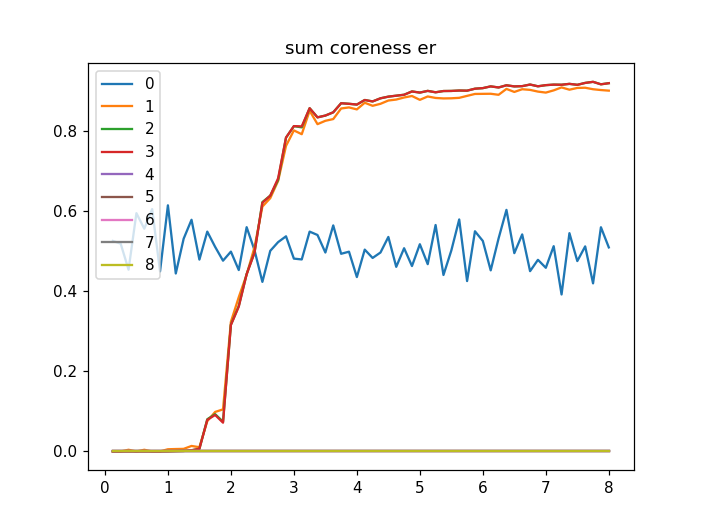

In [22]:
plot_means(bs, cut_alpha(res_sum, 0), 10, list(range(9)), 'sum coreness er', show_data=False)

<IPython.core.display.Javascript object>


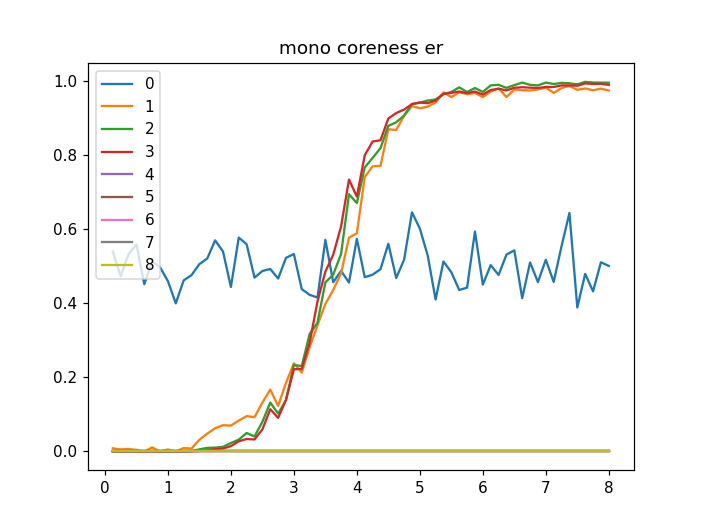

In [18]:
plot_means(bs, cut_alpha(res_mono, 0), 10, list(range(9)), 'mono coreness er', show_data=False)

<IPython.core.display.Javascript object>


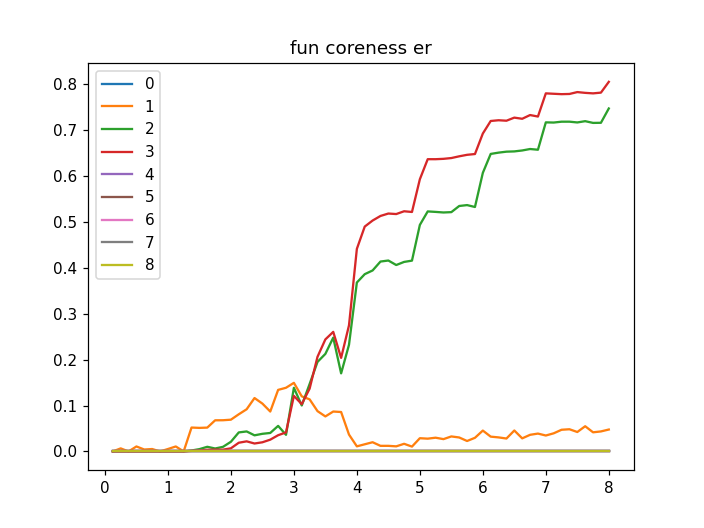

In [15]:
plot_means(bs, cut_alpha(res, 0), 1000, list(range(9)), 'fun coreness er', show_data=False)

<IPython.core.display.Javascript object>


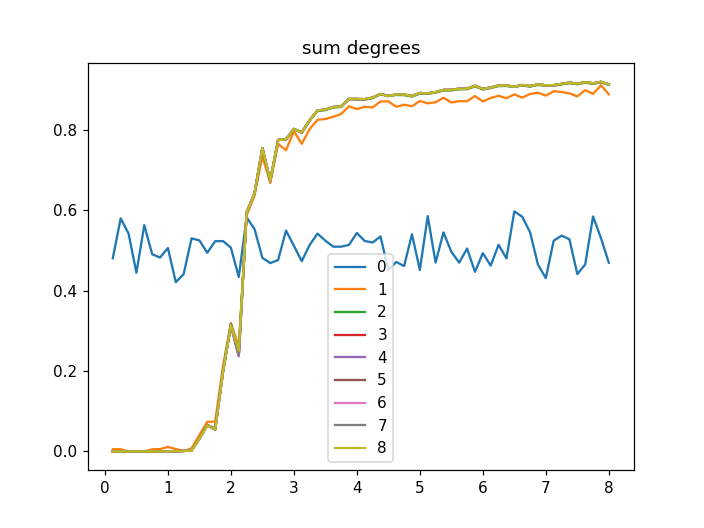

In [28]:
plot_means(bs, cut_alpha(res, 0), 100, list(range(9)), 'sum degrees', show_data=False)